<a href="https://colab.research.google.com/github/jvpf1/CienciaDeDados-Airbnb/blob/main/ProjetoArbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Pervisão de preços de Diária do Airbnb


---
- Neste projeto irei utilizar uma base de dados do Airbnb no Rio de Janeiro.
---
<br>


<b>CONTEXTO</b>
<br>
- O Airbnb é um aplicativo de aluguel de imóveis, seja casa, apartamento, quarto, chalé, etc.
<br>
Qualquer pessoa pode criar um perfil e fazer um anuncio de seu imóvel para alugar.
<br>
O preço é definido apartir de suas características como quatnidade de quarto, espaço interno, banheiros, localização, diárias mínimas, quantidade máxima de hospedes, etc.


<br>

<b>OBJETIVO</b>
- O objetivo final é a construção de um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto cobrar pela diária no aplicativo.


<br>

<b>BASE DE DADOS</b>
- A base de dados foi retirada do site Kaggle: [https://www.kaggle.com/datasets/allanbruno/airbnb-rio-de-janeiro](https://)
- A base de dados compreende o periodo de abril de 2018 até 2020 (junho de 2018 está indisponível)
- A base de dados representa o preço dos imóveis (em Reais R$) e suas respectivas caractrísticas em cada mês.




# Importação bibliotecas e base de dados

In [1]:
import pandas as pd
import pathlib
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split

In [2]:
#Utilizamos uma forma automatizada de ler todos os arquivos que estão na pasta.
#Todos os arquivos foram unidos em um único DataFrame
#Também utilizamos o proprio nome do arquivo para criar duas novas colunas com a informação do ano e do mês referentes.

meses = {'jan':1, 'fev':2, 'mar':3, 'abr':4, 'mai':5, 'jun':6, 'jul':7, 'ago':8, 'set':9, 'out':10, 'nov':11, 'dez':12}

caminho_bases = pathlib.Path('/content/drive/MyDrive/Projeto Ciencia de Dados/Airbnb/dados') # Coloque aqui o caminho de onde salvou a base de dados no seu computador
base_airbnb = pd.DataFrame()


for arquivo in caminho_bases.iterdir():
  nome_mes = arquivo.name[:3]
  mes = meses[nome_mes]

  ano = arquivo.name[-8:]
  ano = int(ano.replace('.csv',''))

  df = pd.read_csv(caminho_bases / arquivo.name)
  df['ano'] = ano
  df['mes'] = mes
  base_airbnb = base_airbnb.append(df)


#Análise

####Excluindo colunas desnecessárias

- Iremos excluir colunas que são desnecessárias para prever o preço do apartamento

In [3]:
#Vou importar os 1000 primeiros registros para um arquivo excel para fazer uma análise de quais colunas poderei excluir.

base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

#Após analise, essas são as colunas que importam para a análise.
colunas = ['host_response_time','host_response_rate', 'host_is_superhost','host_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','ano','mes']
base_airbnb = base_airbnb.loc[:, colunas]
base_airbnb.head()

,host_response_time,host_response_rate,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes
0,within an hour,100%,t,2.0,-22.96592,-43.17896,Condominium,Entire home/apt,5,1.0,...,10.0,10.0,10.0,10.0,9.0,t,f,strict_14_with_grace_period,2019,9
1,within a few hours,100%,f,3.0,-22.97712,-43.19045,Apartment,Entire home/apt,3,1.0,...,10.0,9.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,9
2,within an hour,100%,t,1.0,-22.98302,-43.21427,Apartment,Entire home/apt,3,1.0,...,10.0,10.0,10.0,10.0,10.0,t,f,strict_14_with_grace_period,2019,9
3,within a few hours,100%,t,1.0,-22.98816,-43.19359,Apartment,Entire home/apt,3,1.5,...,9.0,10.0,10.0,10.0,9.0,f,f,strict_14_with_grace_period,2019,9
4,within an hour,100%,t,1.0,-22.98127,-43.19046,Loft,Entire home/apt,2,1.0,...,10.0,10.0,10.0,10.0,10.0,f,f,strict_14_with_grace_period,2019,9


####Tratando valores nulos

In [4]:
base_airbnb.isnull().sum()

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

- Algumas colunas possuem mais da metade dos dados NaN, então vamos retirar elas do modelo.
- Decidimos retirar as colunas que possuem mais do que 300 mil dados NaN.

In [5]:
# Removendo todas as colunas com mais de 300.000 dados nulos
base_airbnb = base_airbnb.dropna(axis=1, thresh=len(base_airbnb) - 300000)

In [6]:
#Removendo as linhas que ainda continham valores nulos
base_airbnb.dropna(inplace=True)

#### Tratando tipos de dados

In [7]:
base_airbnb.dtypes

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object

- Iremos alterar o tipo de dado das colunas price, extra_people

In [8]:
#Alterando a coluna [price]
base_airbnb['price'] = base_airbnb['price'].str.replace('$','') #A coluna de preço está com um $ na frente do valor, entao deveremos retira-lo
base_airbnb['price'] = base_airbnb['price'].str.replace(',','') #O separador de milhar está com ','
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)


#Alterando a coluna [extra_people]
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$','') #A coluna de preço está com um $ na frente do valor, entao deveremos retira-lo
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',','') #O separador de milhar está com ','
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

In [9]:
base_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 897709 entries, 0 to 37244
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   host_is_superhost         897709 non-null  object 
 1   host_listings_count       897709 non-null  float64
 2   latitude                  897709 non-null  float64
 3   longitude                 897709 non-null  float64
 4   property_type             897709 non-null  object 
 5   room_type                 897709 non-null  object 
 6   accommodates              897709 non-null  int64  
 7   bathrooms                 897709 non-null  float64
 8   bedrooms                  897709 non-null  float64
 9   beds                      897709 non-null  float64
 10  bed_type                  897709 non-null  object 
 11  amenities                 897709 non-null  object 
 12  price                     897709 non-null  float32
 13  guests_included           897709 non-null  in

#### Tratando colunas numéricas e retirando outliers

In [10]:
base_airbnb['ano'].nunique()

3

<Axes: >

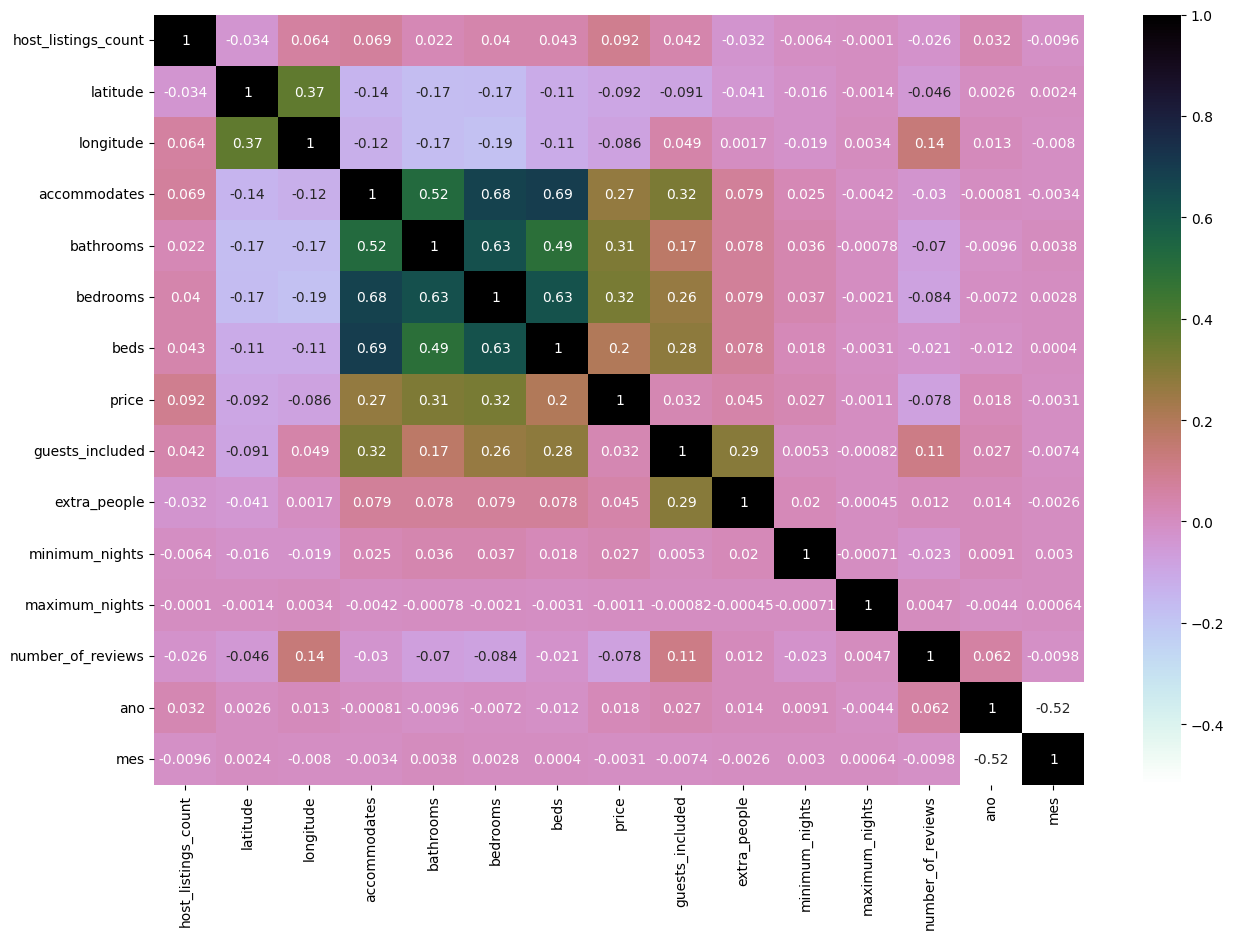

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(base_airbnb.corr(),annot=True,cmap='cubehelix_r')

---

- Agora, iremos analisar os outliers do modelo

Funções para os outliers

In [12]:
#Definir função para retornar o limite do outlier
def limites(coluna):
  q1 = coluna.quantile(0.25)
  q3 = coluna.quantile(0.75)
  amplitude = q3 - q1

  return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude


#Criando função para excluir outliers
def excluirOutliers(df, coluna):
  qtd_linhas = df.shape[0]
  lim_inf, lim_sup = limites(df[coluna])
  df = df.loc[(df[coluna] >= lim_inf) & (df[coluna] <= lim_sup), :]
  linhasRemovidas = qtd_linhas - df.shape[0]

  return df, linhasRemovidas

Funções para os gráficos

In [13]:
#Definir função para plotar diagrama de caixa
def diagramaCaixa(coluna):
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(15,3)
  sns.boxplot(x=coluna, ax=ax1)
  ax2.set_xlim(limites(coluna))
  sns.boxplot(x=coluna, ax=ax2)


#Definir função para plotar histograma
def histograma(coluna):
  plt.figure(figsize=(15,3))
  sns.distplot(coluna, hist=True)


#Definindo função para plotar gráfico de barras
def barras(coluna):
  plt.figure(figsize=(15,3))
  ax = sns.barplot(x=coluna.value_counts().index , y=coluna.value_counts())
  ax.set_xlim(limites(coluna))

---

#####Análise coluna price

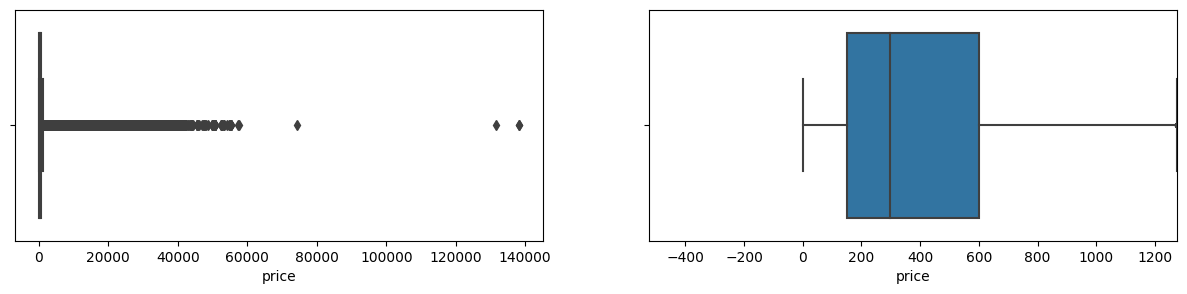

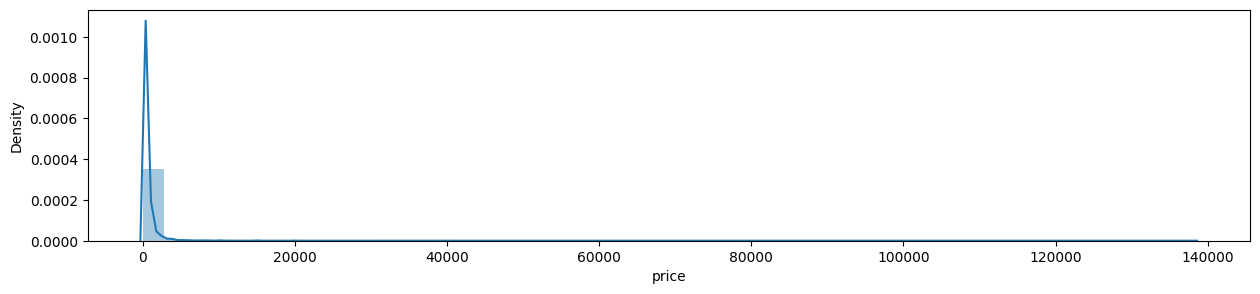

In [14]:
diagramaCaixa(base_airbnb['price'])
histograma(base_airbnb['price'])

- Iremos excluir os outliers, pois os apartamentos que estão com preço acima de 1200 reais nao interessam para a minha análise. A pessoa foco desse trabalho são usuários comuns, e não usuários com mansões e imóveis de altissimo padrão.

In [15]:
base_airbnb, linhasRemovidas = excluirOutliers(base_airbnb, 'price')
print("{} linhas removidas na coluna price".format(linhasRemovidas))

87282 linhas removidas na coluna price


- Gráfico após a retirada dos outliers

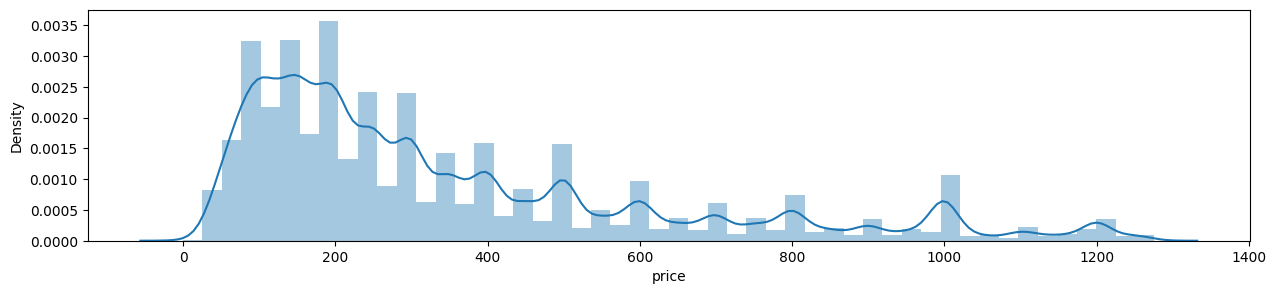

In [16]:
histograma(base_airbnb['price'])

#####Análise coluna extra_people

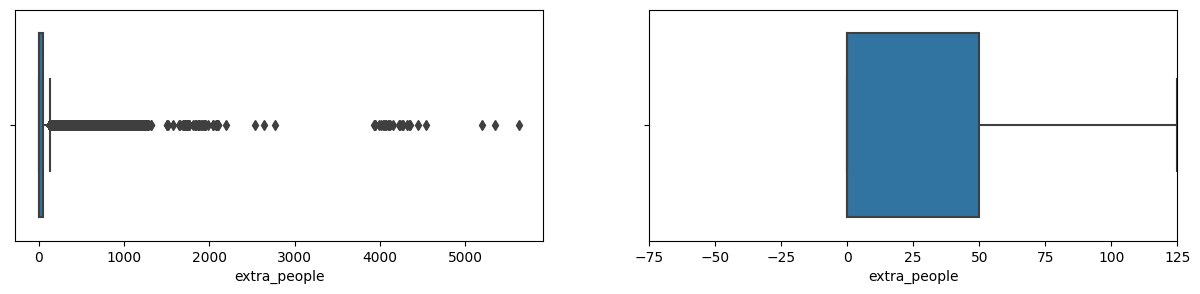

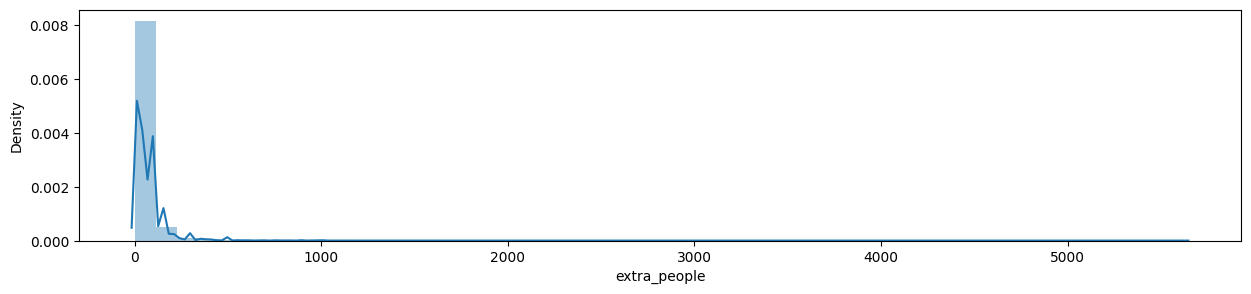

In [17]:
diagramaCaixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

- Iremos retirar os outliers desta coluna.


In [18]:
base_airbnb, linhasRemovidas = excluirOutliers(base_airbnb, 'extra_people')
print("{} linhas removidas na coluna price".format(linhasRemovidas))

59194 linhas removidas na coluna price


- Gráfico após a retirada dos outliers

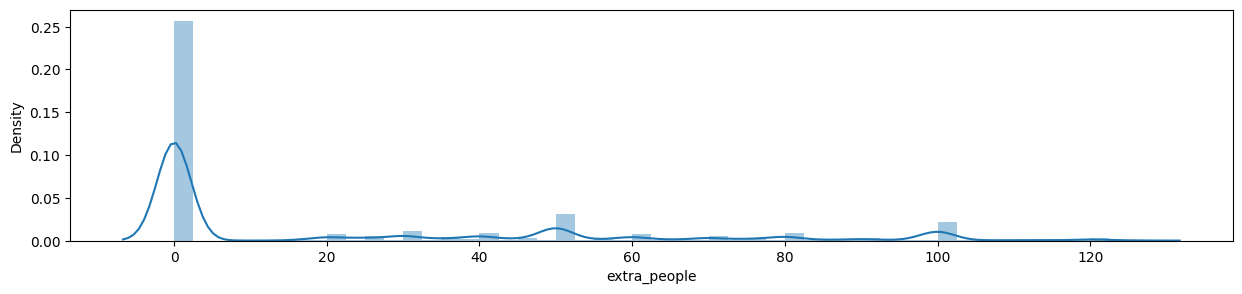

In [19]:
histograma(base_airbnb['extra_people'])

#####Análise coluna host_listings_counts

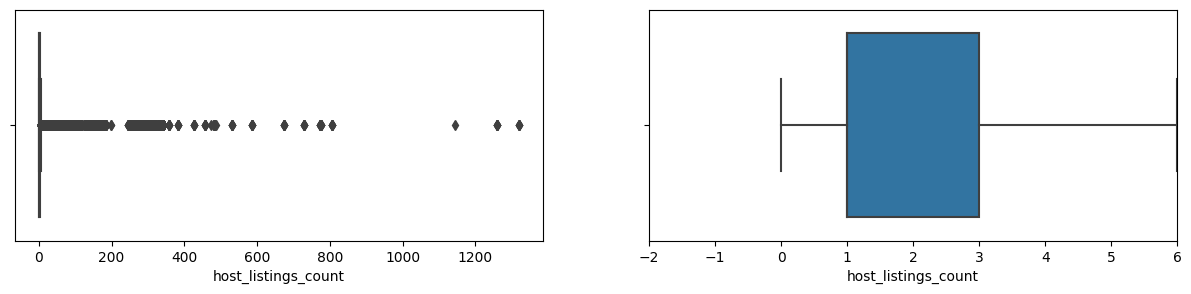

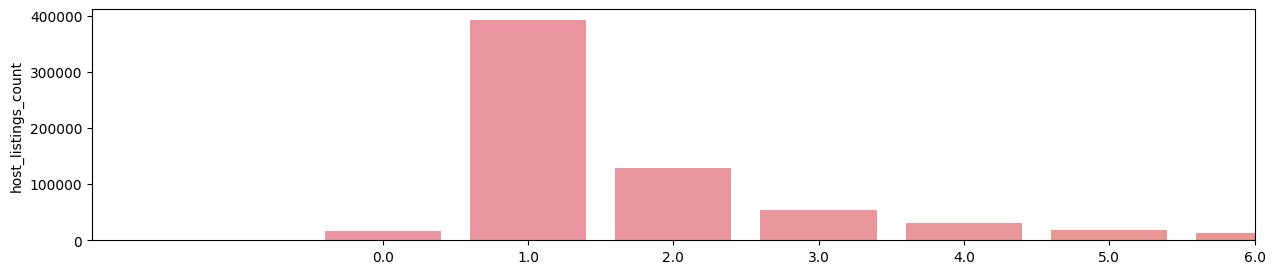

In [20]:
diagramaCaixa(base_airbnb['host_listings_count'])
barras(base_airbnb['host_listings_count'])

- Decidi excluir os outliers pois o objetivo dessa análise é a previsão de preços para um imóvel de uma pessoa comum, e dificilmente uma pessoa assim teria mais do que 6 imóveis para alugar.
- Certamente os dados dos hosts que possuem mais do que essa quantidade, são imobiliárias

In [21]:
base_airbnb, linhasRemovidas = excluirOutliers(base_airbnb, 'host_listings_count')
print("{} linhas removidas na coluna price".format(linhasRemovidas))

97723 linhas removidas na coluna price


#####Análise coluna accomodates

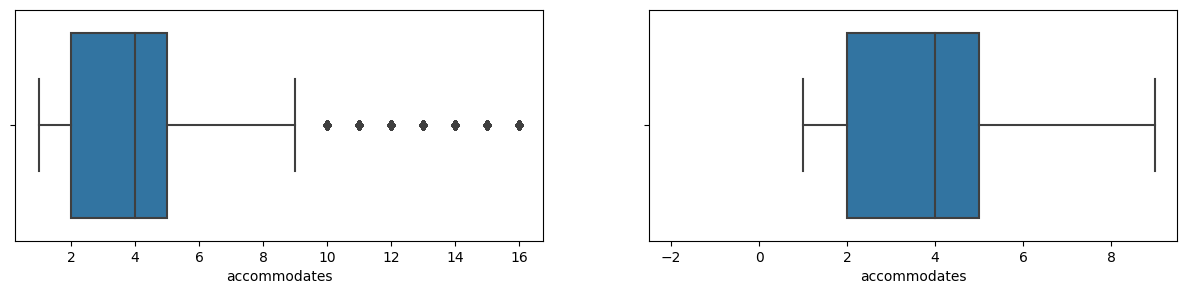

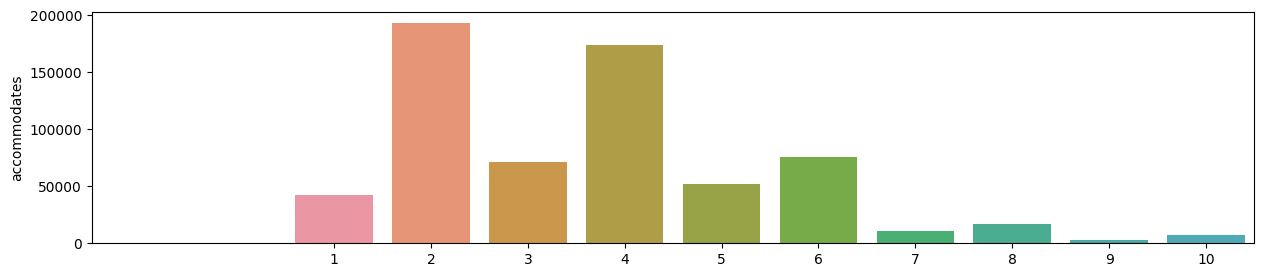

In [22]:
diagramaCaixa(base_airbnb['accommodates'])
barras(base_airbnb['accommodates'])

- Excluindo os outliers

In [23]:
base_airbnb, linhasRemovidas = excluirOutliers(base_airbnb, 'accommodates')
print("{} linhas removidas na coluna price".format(linhasRemovidas))

13146 linhas removidas na coluna price


#####Análise coluna bathrooms

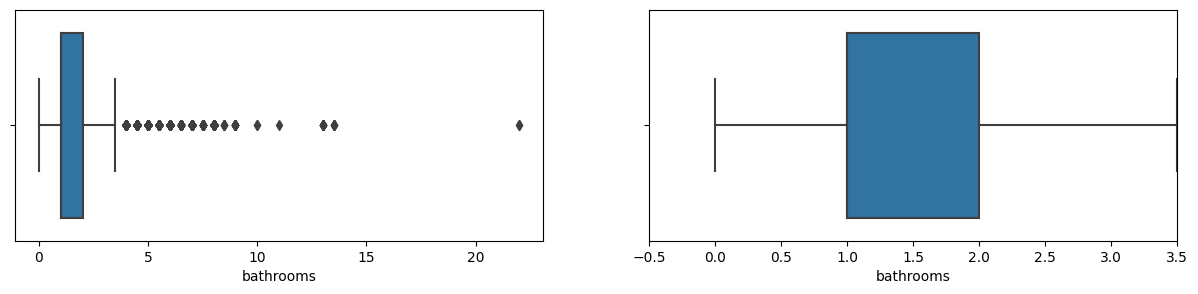

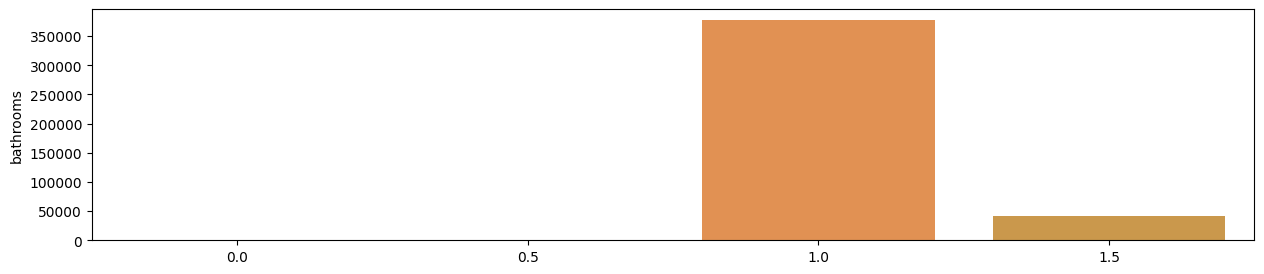

In [24]:
diagramaCaixa(base_airbnb['bathrooms'])
barras(base_airbnb['bathrooms'])

- Excluindo os outliers

In [25]:
base_airbnb, linhasRemovidas = excluirOutliers(base_airbnb, 'bathrooms')
print("{} linhas removidas na coluna price".format(linhasRemovidas))

6894 linhas removidas na coluna price


#####Análise coluna bedrooms

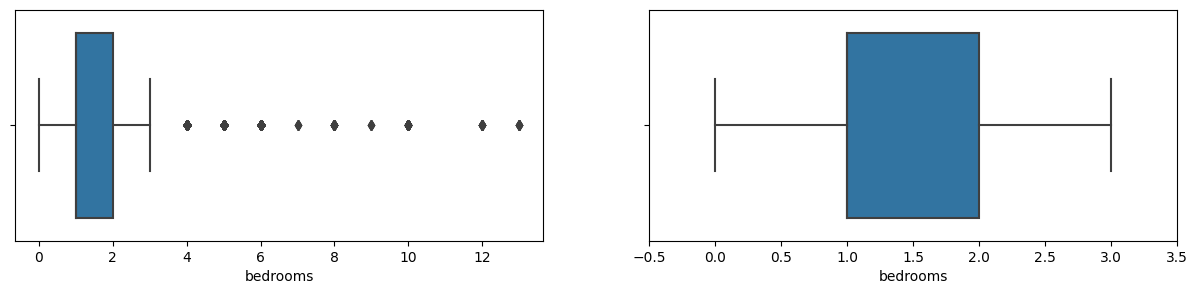

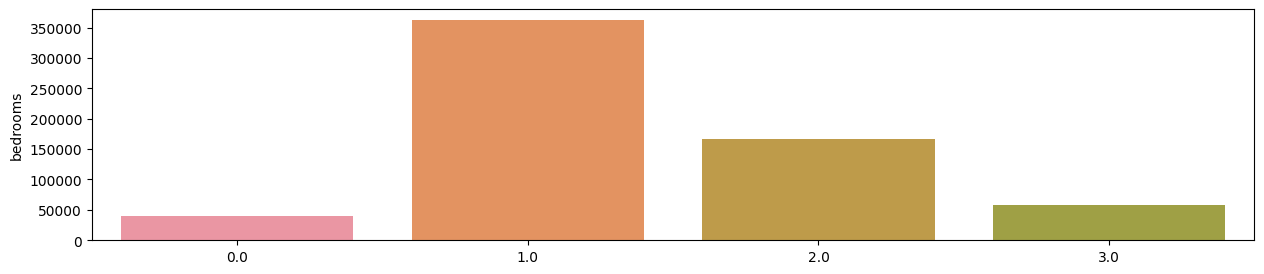

In [26]:
diagramaCaixa(base_airbnb['bedrooms'])
barras(base_airbnb['bedrooms'])

- Excluindo os outliers

In [27]:
base_airbnb, linhasRemovidas = excluirOutliers(base_airbnb, 'bedrooms')
print("{} linhas removidas na coluna price".format(linhasRemovidas))

5482 linhas removidas na coluna price


#####Análise coluna beds

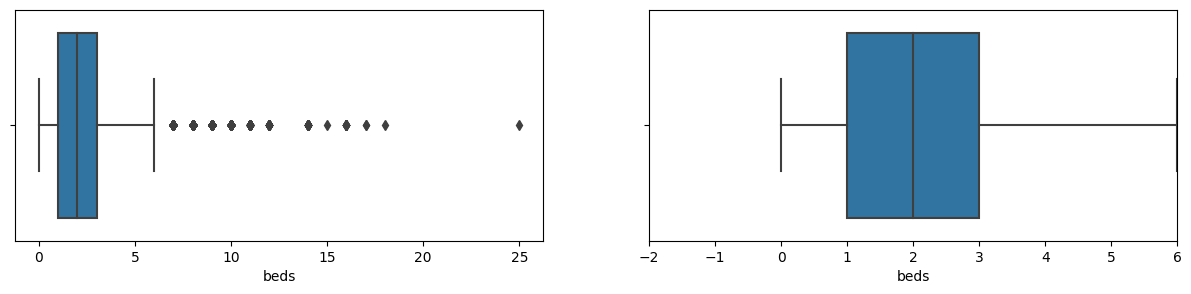

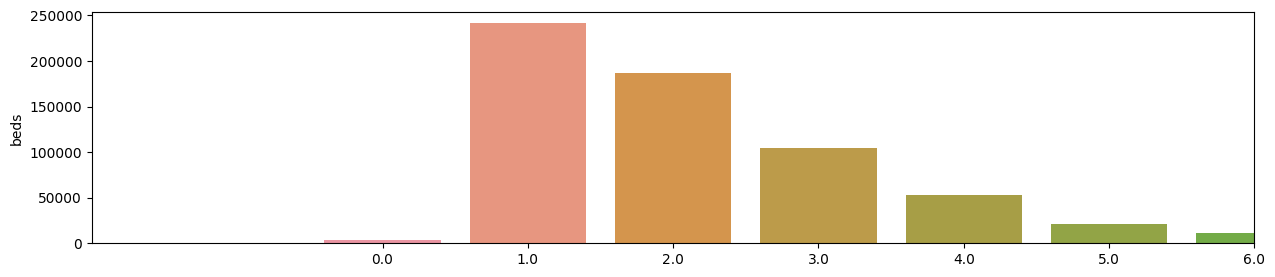

In [28]:
diagramaCaixa(base_airbnb['beds'])
barras(base_airbnb['beds'])

- Excluindo outliers

In [29]:
base_airbnb, linhasRemovidas = excluirOutliers(base_airbnb, 'beds')
print("{} linhas removidas na coluna price".format(linhasRemovidas))

5622 linhas removidas na coluna price


#####Análise coluna guests_included

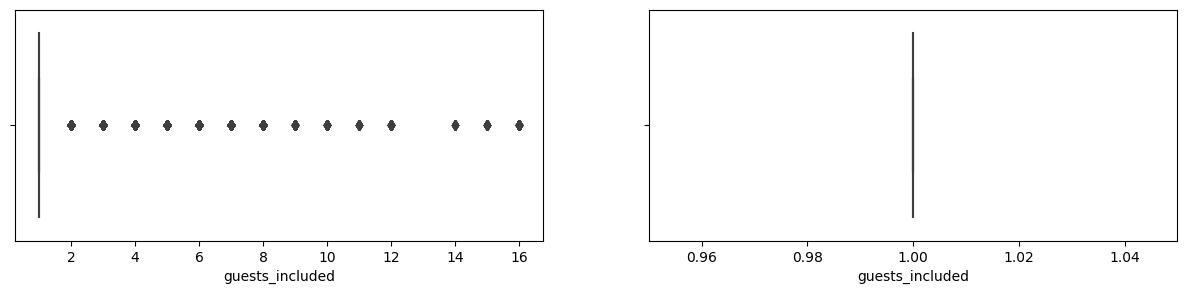

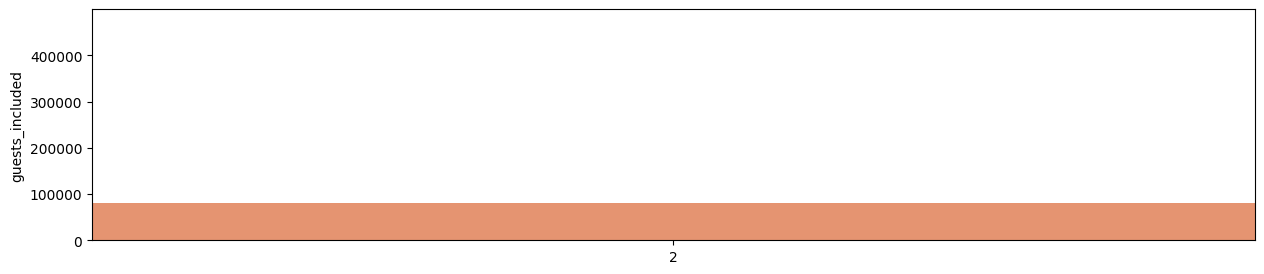

In [30]:
diagramaCaixa(base_airbnb['guests_included'])
barras(base_airbnb['guests_included'])

- Essa coluna possui os valores muito próximo de limite, o que leva a dizer que todos os valores são 1.
- Por isso, decidi remover essa coluna da análise

In [31]:
base_airbnb.drop('guests_included', axis=1, inplace=True)

#####Análise coluna minimum_nights

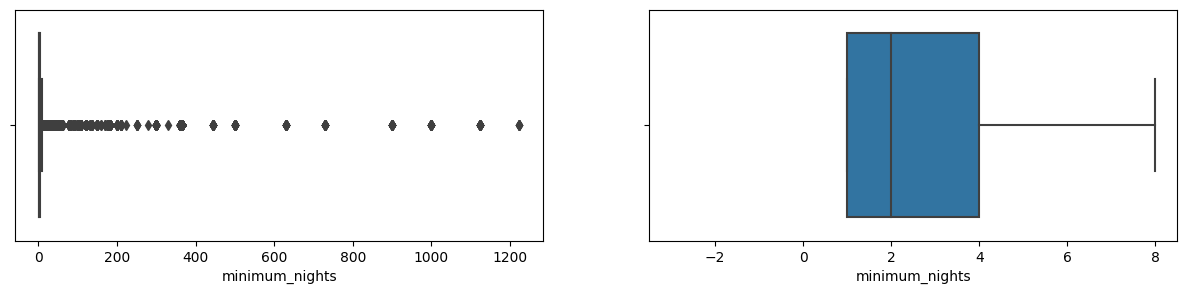

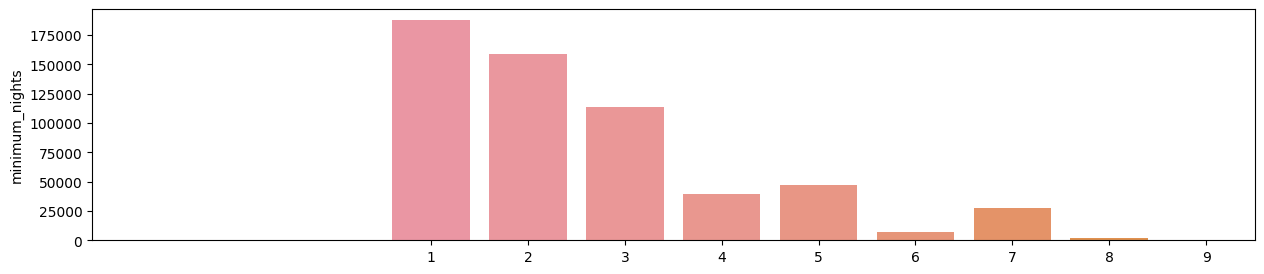

In [32]:
diagramaCaixa(base_airbnb['minimum_nights'])
barras(base_airbnb['minimum_nights'])

-  Excluindo outliers

In [33]:
base_airbnb, linhasRemovidas = excluirOutliers(base_airbnb, 'minimum_nights')
print("{} linhas removidas na coluna price".format(linhasRemovidas))

40383 linhas removidas na coluna price


#####Análise coluna maximum_nights

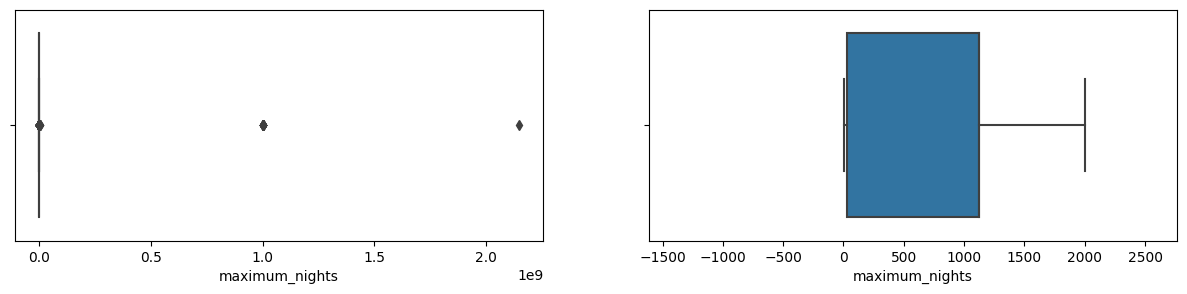

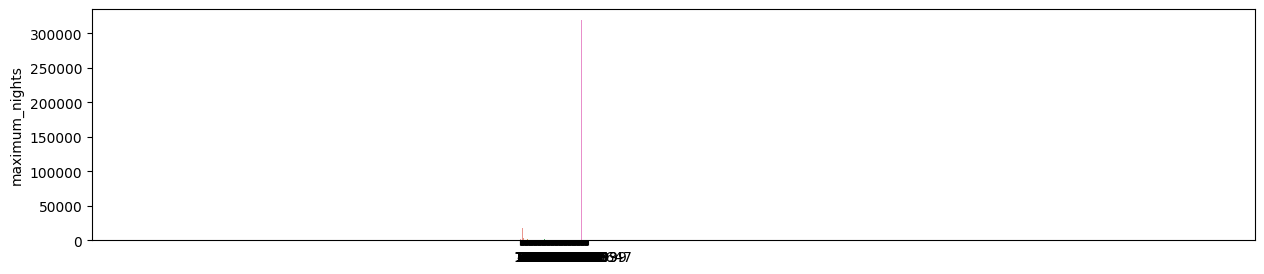

In [34]:
diagramaCaixa(base_airbnb['maximum_nights'])
barras(base_airbnb['maximum_nights'])

- Com base nos gráfico, os usuários aparentam não se importar com o valor de máximo de noites e acabam preenchendo um valor muito alto somente para não deixar o campo de preenchimento em branco.
- Visto isso, essa métrica não irá impactar diretamente o valor do imóvel. Então vamos exclui-la da análise

In [35]:
base_airbnb.drop('maximum_nights', axis=1, inplace=True)

#####Análise coluna number_of_reviews

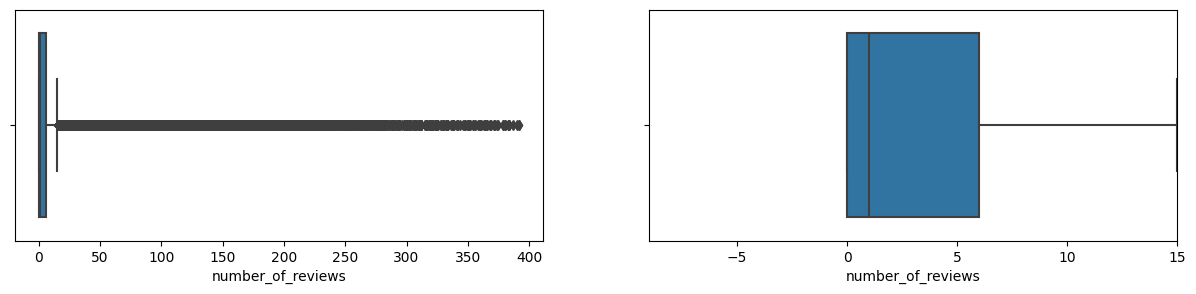

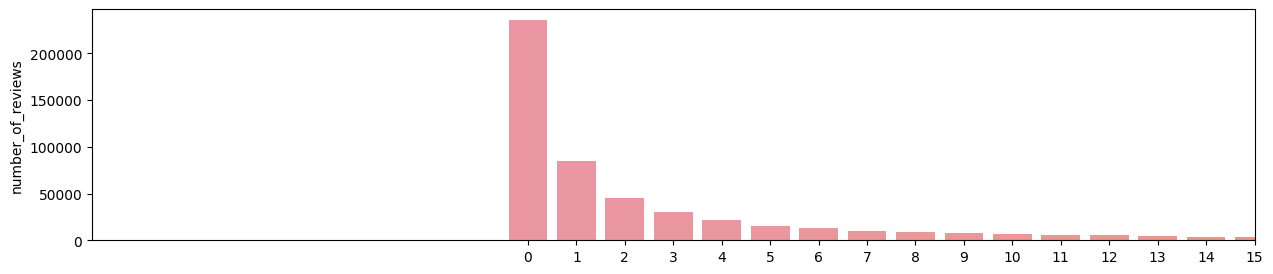

In [36]:
diagramaCaixa(base_airbnb['number_of_reviews'])
barras(base_airbnb['number_of_reviews'])

- O número de reviews impacta muito o valor do aluguel, então não é necessário retirar os outliers, pois uma pessoa com muitas avaliações poderá aumentar o valor por passar confiança aos clientes.
- Porém, essa análise é para um novo inquilino no Airbnb, então ele não possui avaliações em seu perfil. Por isso, iremos retirar essa coluna da análise


In [37]:
base_airbnb.drop('number_of_reviews', axis=1, inplace=True)

### Tratando colunas categóricas

##### Análise coluna property_type

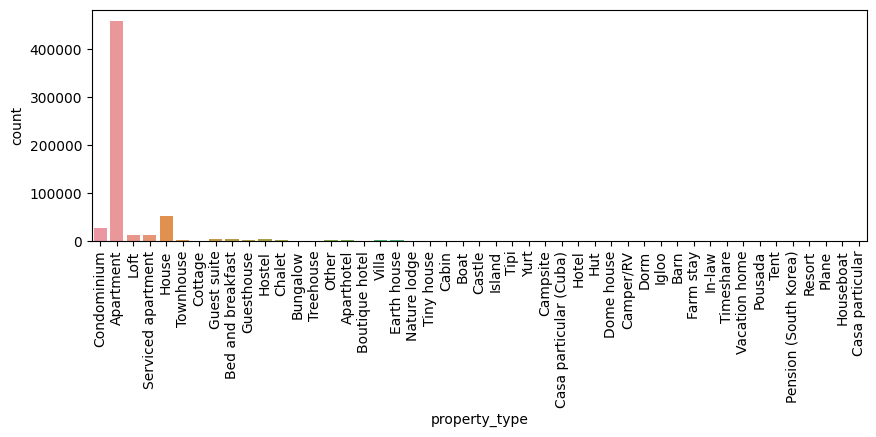

In [38]:
plt.figure(figsize=(10, 3))
grafico = sns.countplot(data=base_airbnb, x='property_type')
grafico.tick_params(axis='x', rotation=90)

- Como temos muitas categorias, vamos transformar todos os que tem menos de 2000 aparições na categorias "others".

In [39]:
tabela_tiposCasa = base_airbnb['property_type'].value_counts()
# Criar uma lista dos valores que ocorrem menos de 2000 vezes
values_to_update = tabela_tiposCasa[tabela_tiposCasa < 2000].index.tolist()

# Atualizar as linhas com esses valores para "Other"
base_airbnb.loc[base_airbnb['property_type'].isin(values_to_update), 'property_type'] = "Other"

In [40]:
base_airbnb['property_type'].value_counts()

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Other                   8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64

##### Análise coluna room_type


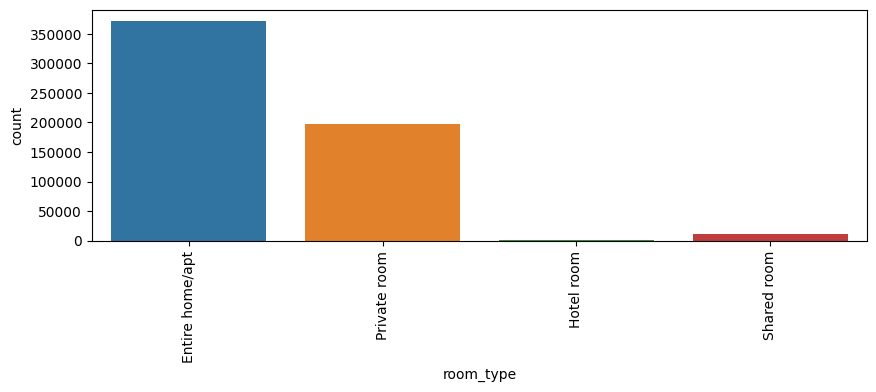

In [41]:
plt.figure(figsize=(10, 3))
grafico = sns.countplot(data=base_airbnb, x='room_type')
grafico.tick_params(axis='x', rotation=90)

- Como temos poucas categorias, iremos mante-las

##### Análise coluna bed_type

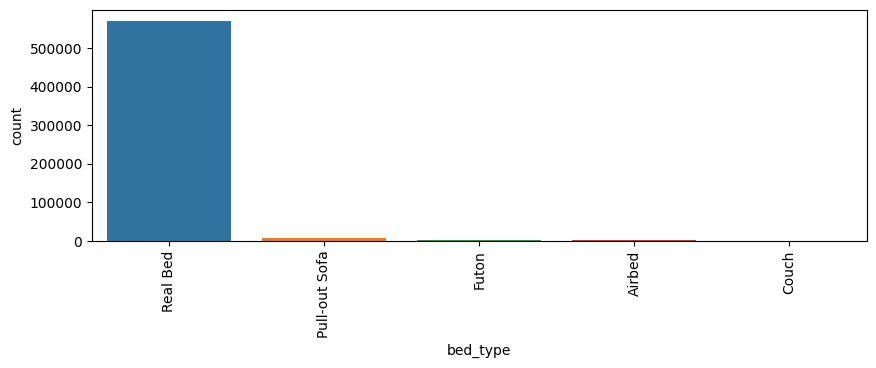

In [42]:
plt.figure(figsize=(10, 3))
grafico = sns.countplot(data=base_airbnb, x='bed_type')
grafico.tick_params(axis='x', rotation=90)

In [43]:
base_airbnb['bed_type'].value_counts()

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64

- Como a o tipo 'Real Bed' é o unico expressivo, e acredito que qualquer outro tipo de cama que nao seja uma cama de fato deve impactar negativamente o preço, irei juntar as demais categorias com o nomo 'Other'

In [44]:
tabela_tiposCama = base_airbnb['bed_type'].value_counts()

# Criar uma lista dos valores que ocorrem menos de 9000 vezes
values_to_update = tabela_tiposCama[tabela_tiposCama < 9000].index.tolist()

# Atualizar as linhas com esses valores para "Other"
base_airbnb.loc[base_airbnb['bed_type'].isin(values_to_update), 'bed_type'] = "Other"

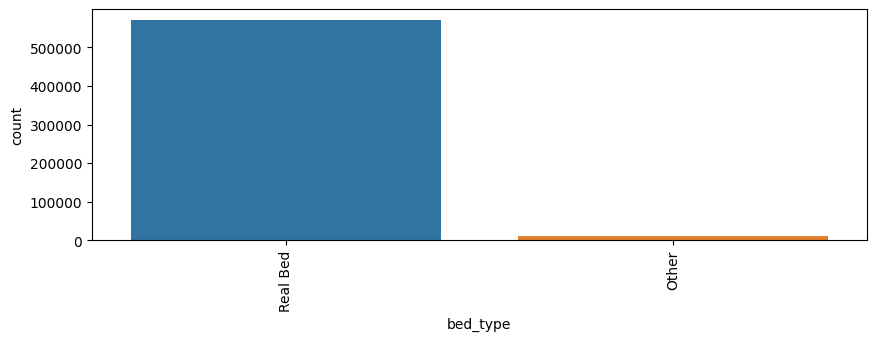

In [45]:
plt.figure(figsize=(10, 3))
grafico = sns.countplot(data=base_airbnb, x='bed_type')
grafico.tick_params(axis='x', rotation=90)

##### Análise coluna cancelation_policy

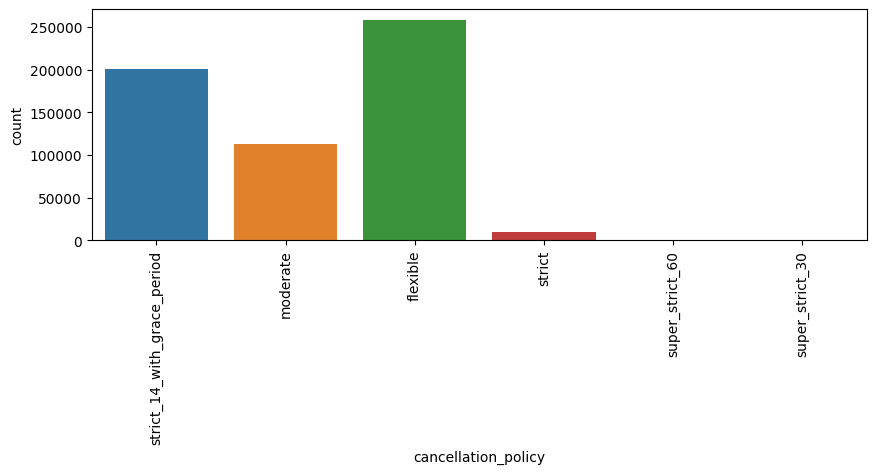

In [46]:
plt.figure(figsize=(10, 3))
grafico = sns.countplot(data=base_airbnb, x='cancellation_policy')
grafico.tick_params(axis='x', rotation=90)

- Os tipos 'Strict', 'Super strict_60' e 'Super strict_30' possuem valores muito próximos, entao iremos agrupalos como 'Strict'

In [47]:
tabela_tiposCancellation = base_airbnb['cancellation_policy'].value_counts()

# Criar uma lista dos valores que ocorrem menos de 10000 vezes
values_to_update = tabela_tiposCancellation[tabela_tiposCancellation < 10000].index.tolist()

# Atualizar as linhas com esses valores para "Other"
base_airbnb.loc[base_airbnb['cancellation_policy'].isin(values_to_update), 'cancellation_policy'] = "Strict"

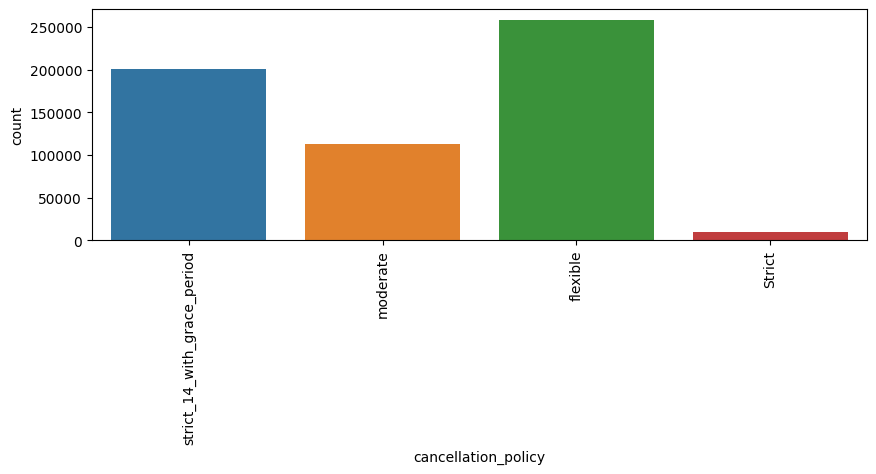

In [48]:
plt.figure(figsize=(10, 3))
grafico = sns.countplot(data=base_airbnb, x='cancellation_policy')
grafico.tick_params(axis='x', rotation=90)

##### Análise coluna amenities

In [49]:
base_airbnb['amenities'].head()

0    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
1    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
2    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
3    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
4    {TV,"Cable TV",Wifi,"Air conditioning",Kitchen...
Name: amenities, dtype: object

- Como fica muito complicado analisar cada linha da coluna amenities, pois cada um escreve de um modo, iremos fazer a contagem de quantos itens cada host escreveu na sua descrição. O que nos leva a ter duas opiniões:

    - O anúncio do imovél que tem mais amenities é melhor;
    - O host que escreve mais é mais detalhista e atencioso, e por isso o valor dele poderia ser maior como meio de 'confiança'.

In [50]:
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)
base_airbnb.drop('amenities', axis=1, inplace=True)

In [51]:
base_airbnb.head()

,host_is_superhost,host_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,price,extra_people,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,ano,mes,n_amenities
0,t,2.0,-22.96592,-43.17896,Condominium,Entire home/apt,5,1.0,2.0,2.0,Real Bed,329.0,62.0,4,t,f,strict_14_with_grace_period,2019,9,33
1,f,3.0,-22.97712,-43.19045,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,158.0,45.0,7,f,f,strict_14_with_grace_period,2019,9,14
2,t,1.0,-22.98302,-43.21427,Apartment,Entire home/apt,3,1.0,1.0,2.0,Real Bed,270.0,42.0,2,t,f,strict_14_with_grace_period,2019,9,25
3,t,1.0,-22.98816,-43.19359,Apartment,Entire home/apt,3,1.5,1.0,2.0,Real Bed,374.0,62.0,2,f,f,strict_14_with_grace_period,2019,9,31
4,t,1.0,-22.98127,-43.19046,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,129.0,80.0,3,f,f,strict_14_with_grace_period,2019,9,41


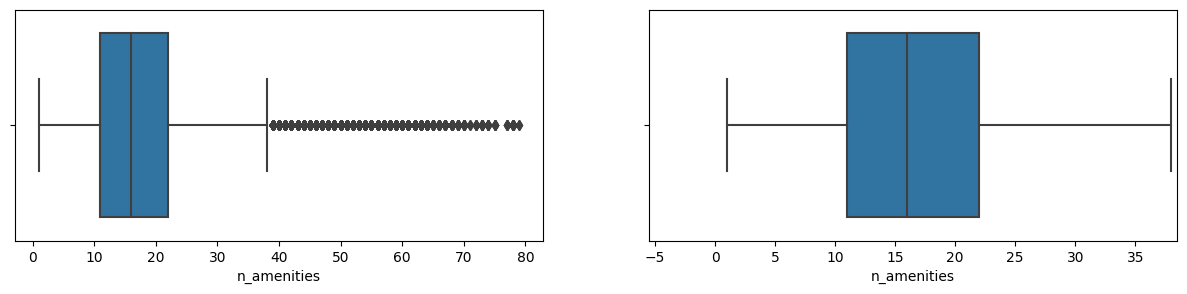

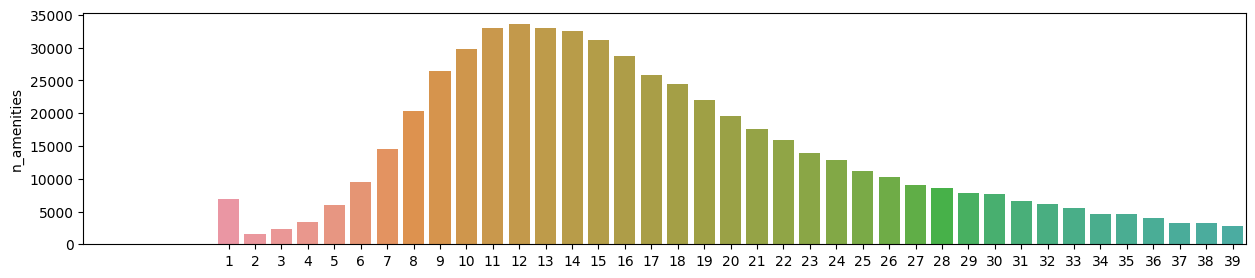

In [52]:
diagramaCaixa(base_airbnb['n_amenities'])
barras(base_airbnb['n_amenities'])

- Excluindo outliers

In [53]:
base_airbnb, linhasRemovidas = excluirOutliers(base_airbnb, 'n_amenities')
print("{} linhas removidas na coluna price".format(linhasRemovidas))

24343 linhas removidas na coluna price


### Visualização de Mapa das propriedades

In [54]:
amostra = base_airbnb.sample(75000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon': amostra.longitude.mean()}

mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain')

mapa.show()

- Como a base é muito grande, colocamos somente uma amostra da base para mostrar o gráfico.

### Encoding


- Nessa seção iremos aplicar métodos para transformar variáveis categóricas em númericas.
- Features que estão com *V ou F*, vamos substituir para 1 e 0.
- Nas features com dados *categóricos* vamos utilizar colunas com variáveis Dummies, com o One Hot Encoding

In [55]:
#Tratamento das colunas booleanas.
colunasTF = ['host_is_superhost','instant_bookable', 'is_business_travel_ready']
base_airbnb_cod = base_airbnb
base_airbnb_cod[colunasTF] = base_airbnb[colunasTF].replace({'t': 1, 'f': 0})

In [56]:
#Tratamendo das colunas categóricas
colunasCategoria = ['property_type', 'room_type', 'bed_type','cancellation_policy']
base_airbnb_cod = pd.get_dummies(data= base_airbnb_cod, columns= colunasCategoria,)

### Criação do modelo de Machine Learning

- Nosso problema é uma regressão

---
-  As métricas de avaliação que iremos utilizar são: R² e RMSE


In [57]:
#Criando função para avaliar o modelo. (como vamos repetir essa avaliação muitas vezes, iremos criar uma função para facilitar)
def avaliar_modelo(nome_modelo, y_teste, previsao):
  r2 = r2_score(y_teste, previsao)
  RMSE = mean_squared_error(y_teste, previsao, squared=False)
  return f'Modelo {nome_modelo}:\nR²: {r2:.2%}\nRMSE: {RMSE:.2f}\n'

- Iremos utilizar 3 modelos: Regressão Linear, Random Forest e Extra Trees

In [58]:
modelo_RandomForest = RandomForestRegressor()
modelo_LinearRegression = LinearRegression()
modelo_ExtraTrees = ExtraTreesRegressor()

modelos = {'RandomForest':modelo_RandomForest,
           'LinearRegression':modelo_LinearRegression,
           'ExtraTrees':modelo_ExtraTrees
           }

#Agora, faremos a divisão em dados de X e Y

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

#Separação em treino e teste do modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

- Agora, iremos treinar os modelos

In [59]:
for nome_modelo, modelo in modelos.items():
  #Treinar
  modelo.fit(X_train, y_train)
  #testar
  previsao = modelo.predict(X_test)
  print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²: 97.20%
RMSE: 44.08

Modelo LinearRegression:
R²: 32.69%
RMSE: 216.30

Modelo ExtraTrees:
R²: 97.50%
RMSE: 41.68



- **Modelo escolhido: EXTRA TREES**
<br>
<br>
Resultado do modelo vencedor: <br>
R²: 97.49% <br>
RMSE: 41.73

- Analisando as métricas de R² e RMSE, percebemos que o modelo que perfoermou melhor foi o Extra Trees. Outro ponto que satisfaz esse modelo também é o tempo de treino, que é mais rápido que o RandomForest, que também obteve resltados parecidos

##### Melhores features

- Vamos usar o método feature_importances_ para ver a importância de cada coluna que está sendo usada. Após isso, iremos analisar e ver se podemos retirar as colunas menos importantes.
- Com isso, podemos simplificar nosso modelo, tornando mais acertivo e mais rápida a execução.

In [60]:
importancia_features = pd.DataFrame(modelo_ExtraTrees.feature_importances_, X_train.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
importancia_features

,0
latitude,0.104793
bedrooms,0.102864
longitude,0.101537
n_amenities,0.088452
extra_people,0.086912
bathrooms,0.076727
accommodates,0.072399
room_type_Entire home/apt,0.070222
minimum_nights,0.065233
beds,0.052810


In [61]:
px.bar(importancia_features, title='Importancia das features no modelo')

Análise das features
 - Número de quartos é a característica que mais impacta no preço;
 - Em seguida a localização. No Rio de Janeiro é percebida uma grande desigualdade, em que a Zona Sul e um pedaço da Zona Oeste concentram a maioria dos pontos turísticos e atrações. O que leva a ter imóveis mais caros nessas regiões. Também pe notado que imóveis perto do parque olímpico recebem um valor maior, pois esse local sedia grandes eventos como Rock in Rio.
 - Número de amenities também impacta muito o preço dos imóveis. O que nos leva a ter a análise que imóveis que tenham mais mordomais tendem a ter o preço mais elevado.
 - A coluna is_business_travel_ready apresentou 0% de importância. O que significa que o modelo não utilizou ela. Então, iremos retiar da base de dados.

##### Exclusão de features com pouca importância

- Agora, iremos excluir as features com pouca importância;
- Depois vamos treinar novamente com o modelo vencedor (ExtraTree);
- E então, comparar as métricas para ver se tivemos melhorias.

In [62]:
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

y = base_airbnb_cod['price']
X = base_airbnb_cod.drop('price', axis=1)

#Separação em treino e teste do modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

modelo_ExtraTrees.fit(X_train, y_train)
previsao = modelo.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²: 97.50%
RMSE: 41.70



- A retirada desta coluna impactou positivamente o nosso modelo. Pois obtivemos melhores métricas de avaliação.

## Fim do Modelo

## Deploy do prorejo
<br>
- Em outro arquivo python, irei fazer a criação de um deploy do modelo.
<br>
- Vou utiliar o Streamlit
<br>
- Nesse tipo de deploy, só é possivel para uso direto, ou seja, estar na mesma rede.

In [64]:
import joblib
joblib.dump(modelo_ExtraTrees, 'modelo.joblib')

['modelo.joblib']